# LDA for COVID-19 Tweet Topic Identification

This notebook to identify the primary topics in COVID-19 vaccine tweets is based on a variety of guides written by others (see bottom of notebook for full list).



First, we load in the packages we'll need - we'll primarily be using Gensim and the Gensim wrapper for Mallet for our LDA. We'll also load in our pre-processed, labeled data.

In [1]:
import pandas as pd
import numpy as np
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import os
import json
import pickle

/home/npodpx/miniconda3/lib/python3.8/site-packages/ipykernel/pylab/config.py:70: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [2]:
tweets = os.listdir('data/labeled')
tweets_dfs = []
for tweet in tweets:
    tw_file = 'data/labeled/' + tweet
    df = pd.read_json(tw_file)
    tweets_dfs.append(df) 
tweets_clean = pd.concat(tweets_dfs)

Filter to include only tweets which are negative, in order to better isolate topics related to vaccine hesitancy.

In [3]:
tweets_negneut = tweets_clean[tweets_clean['score'] < 0]
tweets_negneut.reset_index(inplace=True)

In [4]:
# Define function to create n-grams
def ngrams(text_clean_tok_lst, n):
    output = []
    for i in range(len(text_clean_tok_lst) - n + 1):
        output.append(' '.join(text_clean_tok_lst[i:i + n]))
    return output

In [5]:
import ast
tweets_negneut['digrams'] = None
for i in range(tweets_negneut.shape[0]):
    tweets_negneut['digrams'][i] = ngrams(ast.literal_eval(tweets_negneut['text_cln_tok'][i]), 2)

/tmp/ipykernel_4023/2807922023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_negneut['digrams'] = None
/tmp/ipykernel_4023/2807922023.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_negneut['digrams'][i] = ngrams(ast.literal_eval(tweets_negneut['text_cln_tok'][i]), 2)
/home/npodpx/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

In [29]:
print("""
    Size of combined df:\t{}
    First five rows:

    {}
""".format(
    tweets_negneut.shape,
    tweets_negneut.head()
)
)



    Size of combined df:	(249710, 10)
    First five rows:

       index                created_at  \
0      2 2021-01-01 05:01:46+00:00   
1      7 2021-01-01 05:02:20+00:00   
2      8 2021-01-01 05:02:29+00:00   
3      9 2021-01-01 05:02:34+00:00   
4     11 2021-01-01 05:02:44+00:00   

                                            text_cln  \
0  covid vaccine uk nhs staff struggle jab echo p...   
1  lets end argument nowwethepeople believe virus...   
2  fix headlinedidnt destroy doses intentionally ...   
3                  came way let vaccines bad freezer   
4  authorities arrested milwaukee pharmacist susp...   

                                        text_cln_tok  positive  neutral  \
0  ['nhs', 'staff', 'struggle', 'jab', 'echo', 'p...       0.0    0.753   
1  ['lets', 'end', 'argument', 'nowwethepeople', ...       0.0    0.878   
2  ['fix', 'headlinedidnt', 'destroy', 'doses', '...       0.0    0.615   
3           ['came', 'way', 'let', 'bad', 'freezer']       0.0    0.5

In [23]:
# Store negative tweets with single-word and digram fields
tweets_negneut.to_csv('models/tweets_df.csv')

First (if desired), we can perform a grid search of possible parameters for both the Gensim and Mallet LDA models to identify the most promising. To do this, use the function choose_lda_models() in pipeline.py with the text_cln_tok column of the full tweets dataframe. In order to successfully run pipeline (for the Mallet LDA model), you'll need to download the Mallet LDA (download with: wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip), unzip it, and re-assign the variable MALLET_PATH in pipeline.py to be the file path where the ballet-2.0.8/bin/mallet files are located (eg, MALLET_PATH = '/usr/lib/mallet-2.0.8/bin/mallet'). You also need to insure all packages used in pipeline.py are installed. 

Note on grid search: currently, the parameters to search through are hard-coded in pipeline.py. To search through different parameters, you'll need to adjust the parameter values in choose_lda_models. The initial step of creating a dictionary and corpus to use in the LDA models also takes parameters, which are currently hard-coded to not consider words which appear less than 50 times, words which appear in more than 80 % of the documents, and to filter for only the top 1000000 words. This can also be changed in pipeline.py when build_corpus_dict is called by choose_lda_models.

In [37]:
import pipeline
import importlib
importlib.reload(pipeline)

<module 'pipeline' from '/mnt/c/Users/natra/Documents/Education/UChicago/MLforPP/ml-for-pp_vaccine-hesitancy/pipeline.py'>

In [6]:
results = pipeline.choose_lda_models(tweets_negneut['text_cln_tok'])

se days canada reports year time modi blood country 
1	0.1	people fake don die immunity mask usa virus medicine company wait produced listen dont therapeutics ennaid humanity masks fully cure 
2	0.1	health people emergency world anti biden india school countries pandemic news global private patents doses fight trump patent moderna teachers 

<250> LL/token: -5.23769
<260> LL/token: -5.23402
<270> LL/token: -5.23743
<280> LL/token: -5.23335
<290> LL/token: -5.234

0	0.1	india cases people death health deaths risk total astrazeneca pfizer dose died days canada reports modi time year blood country 
1	0.1	people fake don die immunity mask virus usa medicine company wait produced listen fully therapeutics dont ennaid humanity masks cure 
2	0.1	health emergency people world anti biden countries school india news pandemic global private patents trump doses moderna patent teachers fight 

<300> LL/token: -5.23479
<310> LL/token: -5.23871
<320> LL/token: -5.23671
<330> LL/token: -5.23757
<340> 

In [7]:
results.sort_values('Coherence',ascending=False)

,LDA Model,Params,Time Elapsed,Coherence,Perplexity,Topics
183,GensimLDA,"{'chunksize': 2000, 'num_topics': 10, 'alpha':...",0 days 00:00:28.049147,0.410590,-5.102324,"[(0, 0.167*""cases"" + 0.165*""new"" + 0.164*""deat..."
201,GensimLDA,"{'chunksize': 2000, 'num_topics': 10, 'alpha':...",0 days 00:00:28.520705,0.410590,-5.102324,"[(0, 0.167*""cases"" + 0.165*""new"" + 0.164*""deat..."
75,GensimLDA,"{'chunksize': 1000, 'num_topics': 10, 'alpha':...",0 days 00:00:22.666379,0.407200,-5.080135,"[(0, 0.162*""cases"" + 0.148*""death"" + 0.142*""ne..."
76,GensimLDA,"{'chunksize': 1000, 'num_topics': 10, 'alpha':...",0 days 00:00:21.138000,0.405391,-5.092708,"[(0, 0.161*""cases"" + 0.147*""death"" + 0.141*""ne..."
182,GensimLDA,"{'chunksize': 2000, 'num_topics': 10, 'alpha':...",0 days 00:00:27.381447,0.404054,-5.091282,"[(0, 0.171*""cases"" + 0.168*""new"" + 0.168*""deat..."
...,...,...,...,...,...,...
11,GensimLDA,"{'chunksize': 1000, 'num_topics': 3, 'alpha': ...",0 days 00:00:28.099501,0.222089,-5.1583,"[(0, 0.076*""cases"" + 0.070*""death"" + 0.049*""fa..."
7,GensimLDA,"{'chunksize': 1000, 'num_topics': 3, 'alpha': ...",0 days 00:00:28.290769,0.222089,-5.157852,"[(0, 0.076*""cases"" + 0.070*""death"" + 0.049*""fa..."
43,GensimLDA,"{'chunksize': 1000, 'num_topics': 5, 'alpha': ...",0 days 00:00:22.464876,0.221264,-5.110934,"[(0, 0.091*""cases"" + 0.083*""death"" + 0.080*""ne..."
6,GensimLDA,"{'chunksize': 1000, 'num_topics': 3, 'alpha': ...",0 days 00:00:28.442079,0.220203,-5.212789,"[(0, 0.078*""cases"" + 0.071*""death"" + 0.050*""fa..."


In [11]:
results.to_csv('lda_models_gs_3day.csv')

With Digrams, we can see if the results are better:

In [38]:
results_digrams = pipeline.choose_lda_models(tweets_negneut['digrams'],n_grams=2)

Training model: GensimLDA | {'chunksize': 2000, 'num_topics': 5, 'alpha': 0.1, 'eta': 0.3, 'random_state': 100}
Time Elapsed: 0:19:01.185175
Training model: GensimLDA | {'chunksize': 2000, 'num_topics': 5, 'alpha': 0.1, 'eta': 0.6, 'random_state': 100}
Time Elapsed: 0:18:56.834442
Training model: GensimLDA | {'chunksize': 2000, 'num_topics': 5, 'alpha': 0.1, 'eta': 1, 'random_state': 100}
Time Elapsed: 0:18:58.951225
Training model: GensimLDA | {'chunksize': 2000, 'num_topics': 5, 'alpha': 0.3, 'eta': 0.3, 'random_state': 100}
Time Elapsed: 0:19:39.128580
Training model: GensimLDA | {'chunksize': 2000, 'num_topics': 5, 'alpha': 0.3, 'eta': 0.6, 'random_state': 100}
Time Elapsed: 0:21:32.082821
Training model: GensimLDA | {'chunksize': 2000, 'num_topics': 5, 'alpha': 0.3, 'eta': 1, 'random_state': 100}
Time Elapsed: 0:21:52.424905
Training model: GensimLDA | {'chunksize': 2000, 'num_topics': 5, 'alpha': 0.6, 'eta': 0.3, 'random_state': 100}
Time Elapsed: 0:18:33.972042
Training model: G

In [39]:
results_digrams.sort_values('Coherence',ascending=False)

,LDA Model,Params,Time Elapsed,Coherence,Perplexity,Topics
44,GensimLDA,"{'chunksize': 2000, 'num_topics': 15, 'alpha':...",0 days 00:36:28.389688,0.757583,-18.948309,"[(0, 0.000*""west bank"" + 0.000*""occupying powe..."
38,GensimLDA,"{'chunksize': 2000, 'num_topics': 15, 'alpha':...",0 days 00:36:43.032851,0.638176,-15.394416,"[(0, 0.000*""cases total"" + 0.000*""new cases"" +..."
41,GensimLDA,"{'chunksize': 2000, 'num_topics': 15, 'alpha':...",0 days 00:35:16.650897,0.636046,-15.221475,"[(0, 0.000*""cases total"" + 0.000*""new cases"" +..."
5,GensimLDA,"{'chunksize': 2000, 'num_topics': 5, 'alpha': ...",0 days 00:21:52.424905,0.627306,-15.130175,"[(0, 0.000*""patent protections"" + 0.000*""big p..."
9,GensimLDA,"{'chunksize': 2000, 'num_topics': 5, 'alpha': ...",0 days 00:17:11.253347,0.616733,-15.985495,"[(0, 0.002*""emergency use"" + 0.001*""cases tota..."
36,GensimLDA,"{'chunksize': 2000, 'num_topics': 15, 'alpha':...",0 days 00:38:18.959740,0.586024,-16.623748,"[(0, 0.000*""suspend patents"" + 0.000*""single d..."
10,GensimLDA,"{'chunksize': 2000, 'num_topics': 5, 'alpha': ...",0 days 00:16:20.871814,0.579935,-15.220045,"[(0, 0.001*""emergency use"" + 0.001*""cases tota..."
3,GensimLDA,"{'chunksize': 2000, 'num_topics': 5, 'alpha': ...",0 days 00:19:39.128580,0.579057,-16.211953,"[(0, 0.001*""therapeutics company"" + 0.001*""enn..."
18,GensimLDA,"{'chunksize': 2000, 'num_topics': 10, 'alpha':...",0 days 00:25:32.130381,0.574276,-16.935570,"[(0, 0.001*""cases total"" + 0.001*""new cases"" +..."
11,GensimLDA,"{'chunksize': 2000, 'num_topics': 5, 'alpha': ...",0 days 00:16:18.502464,0.572403,-14.932319,"[(0, 0.001*""emergency use"" + 0.000*""cases tota..."


In [40]:
results_digrams.to_csv('lda_models_gs_digrams_local_tfidf_nolims.csv')

Once the ideal parameters are selected, we can manually create the models to consider specific aspects more in-depth (and to create the dynamic visualizations below). First, we use Gensim to create a dictionary of the unique words that appear mapped to an id. (We are still filtering out from the dictionary words that don't appear enough or appear in too many tweets.) Second, we'll create a corpus of the tweets, which contains the number of times a given word (identified by id) appeared in each tweet. 

In [3]:
# To load previously saved tweet dataframe with text_cln_tok and digram fields:
tweets_negneut = pd.read_csv('models/tweets_df.csv')
tweets_negneut.drop(columns=['Unnamed: 0'],inplace=True)

In [17]:
# For single-word clusters
import ast
tweets_nn_lst = []
for tweet in tweets_negneut['text_cln_tok']:
    tweets_nn_lst.append(ast.literal_eval(tweet))

AttributeError: 'str' object has no attribute 'astype'

In [9]:
# For single-word clusters
single_dict = corpora.Dictionary(tweets_nn_lst)
single_dict.filter_extremes(no_below=100, no_above=0.80, keep_n=1000000)

single_corpus = [single_dict.doc2bow(tweet) for tweet in tweets_nn_lst]

In [6]:
# For digrams if obtained from csv
import ast
tweets_nn_di_lst = []
for tweet in tweets_negneut['digrams']:
    tweets_nn_di_lst.append(ast.literal_eval(tweet))

In [6]:
# For digrams if created within-notebook
tweets_nn_di_lst = []
for tweet in tweets_negneut['digrams']:
    tweets_nn_di_lst.append(tweet)

In [7]:
# For digrams
single_dict = corpora.Dictionary(tweets_nn_di_lst)
single_dict.filter_extremes(no_below=200, no_above=0.80, keep_n=1000000)

single_corpus = [single_dict.doc2bow(tweet) for tweet in tweets_nn_di_lst]
tfidf = models.TfidfModel(single_corpus)
tfidf_corpus = tfidf[single_corpus]

Next, we can train the model with the parameters we identified above (or, with any other parameters).

In [8]:
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
model_2 = gensim.models.ldamodel.LdaModel(corpus=tfidf_corpus,
                                           id2word=single_dict,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=2000,
                                           passes=10,
                                           alpha=0.1,
                                           eta=1,
                                           per_word_topics=True)
                                        

We can store the model and associated dictionary/corpus:

In [9]:
# To store model, dictionary, and corpus for later use:
import pickle
import json
pickle.dump(model_2, open("models/model_2.pkl", "wb"))

In [26]:
# To load model, dictionary, and corpus from previously stored:
model_2 = pickle.load(open("models/model_2.pkl", "rb"))
with open("models/model_2.json") as infile:
    model2_json = json.load(infile)

In [10]:
# View the topics identified in the above model
model_2.print_topics()

[(0,
  '0.163*"johnson johnson" + 0.077*"second wave" + 0.058*"people dying" + 0.058*"fully people" + 0.053*"wear masks" + 0.036*"export ban" + 0.035*"million people" + 0.035*"joe biden" + 0.030*"right now" + 0.025*"people fully"'),
 (1,
  '0.081*"fake cards" + 0.079*"people died" + 0.067*"young people" + 0.061*"new variants" + 0.057*"million doses" + 0.053*"sars cov" + 0.043*"selling fake" + 0.042*"people don" + 0.041*"single dose" + 0.040*"age group"'),
 (2,
  '0.099*"second dose" + 0.072*"anti vax" + 0.063*"high risk" + 0.059*"biden administration" + 0.045*"negative test" + 0.040*"anti vaxxers" + 0.036*"severe disease" + 0.034*"low risk" + 0.033*"fact check" + 0.033*"killing people"'),
 (3,
  '0.092*"private school" + 0.071*"big pharma" + 0.036*"suspend patents" + 0.033*"spike protein" + 0.032*"death rate" + 0.030*"stop spread" + 0.030*"quickly possible" + 0.030*"drop patents" + 0.029*"flu shot" + 0.029*"governments big"'),
 (4,
  '0.069*"blood clots" + 0.045*"joe rogan" + 0.036*"so

We can use Coherence as one method for considering our model's accuracy:

In [45]:
# Compute Coherence Score
single_coherence_model_lda = CoherenceModel(model=model_2, texts=tweets_nn_di_lst, dictionary=single_dict, coherence='c_v')
single_coherence_lda = single_coherence_model_lda.get_coherence()
print(single_coherence_lda)

0.5972937034550574


We can also visualize the topics and their overlap:

In [41]:
pyLDAvis.enable_notebook()
single_plot = pyLDAvis.gensim_models.prepare(model_2, tfidf_corpus, single_dict,sort_topics=False)
single_plot


/home/npodpx/miniconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/npodpx/miniconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/npodpx/miniconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/npodpx/miniconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/npodpx/miniconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: Deprecatio

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.061686  0.227058       1        1   9.634191
1     -0.080737  0.201186       2        1   8.904834
2     -0.044991  0.125564       3        1  10.492682
3      0.096095  0.026889       4        1   9.007468
4      0.238652 -0.115127       5        1  10.100955
5      0.198837 -0.114854       6        1  10.360606
6     -0.010669  0.075313       7        1  10.948060
7     -0.246169 -0.218065       8        1  11.531325
8     -0.200392 -0.172889       9        1   9.955856
9      0.111059 -0.035076      10        1   9.064023, topic_info=                   Term         Freq        Total Category  logprob  loglift
396     johnson johnson  2194.000000  2194.000000  Default  30.0000  30.0000
461  patent protections  1994.000000  1994.000000  Default  29.0000  29.0000
6         emergency use  2177.000000  2177.000000  Default  28.0000  28.0000
22        public health  1807.000000  1807.000000  Default  27.0000  27.0000
8           second dose  1457.000000  1457.000000  Default  26.0000  26.0000
..                  ...          ...          ...      ...      ...      ...
532        aspirin days    87.311283    95.189022  Topic10  -4.9710   2.3145
554        aspirin stop    87.215673    95.110194  Topic10  -4.9721   2.3142
349      outweigh risks   139.032028   180.124329  Topic10  -4.5058   2.1419
190      rich countries   147.297628   223.510540  Topic10  -4.4480   1.9839
379         blood clots   102.505668  1427.836503  Topic10  -4.8106  -0.2331

[346 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
319       1  0.002887    active cases
319       2  0.002887    active cases
319       3  0.002887    active cases
319       4  0.002887    active cases
319       5  0.002887    active cases
...     ...       ...             ...
170       6  0.005122  younger people
170       7  0.005122  younger people
170       8  0.957829  younger people
170       9  0.005122  younger people
170      10  0.005122  younger people

[3120 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

Additionally, we can assign back to each tweet the dominant topic(s) in order to view examples of representative tweets per topic. 

In [13]:
# Code taken and modified from https://www.tutorialspoint.com/gensim/gensim_documents_and_lda_model.htm
def dominant_topics(ldamodel=model_2, corpus=tfidf_corpus, texts=tweets_negneut['text_cln'], dates=tweets_negneut['created_at']):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        #print('i',i,'row',row)
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        #print('sorted row',row)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    dates = pd.Series(dates)
    sent_topics_df = pd.concat([sent_topics_df, contents, dates], axis=1)
    return(sent_topics_df)


In [14]:
df_topic_sents_keywords = dominant_topics()
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
   'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Date'
]

In [15]:
df_dominant_topic['Date_DT'] = pd.to_datetime(df_dominant_topic['Date'])

In [77]:
# Obtain proportion of texts by topic
df_dominant_topic.groupby(['Dominant_Topic','Keywords'])['Document_No'].nunique() / df_dominant_topic['Document_No'].nunique()

Dominant_Topic  Keywords                                                                                                                                                    
0.0             johnson johnson, second wave, people dying, fully people, wear masks, export ban, million people, joe biden, right now, people fully                            0.623872
1.0             fake cards, people died, young people, new variants, million doses, sars cov, selling fake, people don, single dose, age group                                  0.036639
2.0             second dose, anti vax, high risk, biden administration, negative test, anti vaxxers, severe disease, low risk, fact check, killing people                       0.053878
3.0             private school, big pharma, suspend patents, spike protein, death rate, stop spread, quickly possible, drop patents, flu shot, governments big                  0.035802
4.0             blood clots, joe rogan, social distancing, reports death, poor countrie

In [135]:
top200_list = []
for i in range(10):
    topic_num = pd.to_numeric(str(i) + '.0')
    top200=df_dominant_topic[(df_dominant_topic['Dominant_Topic']==topic_num)].sort_values(by=['Topic_Perc_Contrib'], ascending=False).drop_duplicates(['Dominant_Topic','Topic_Perc_Contrib']).head(200)
    top200_list.append(top200)
    
dom_topics_top200 = pd.concat(top200_list)
dom_topics_top200.shape

(2000, 7)

In [136]:
dom_topics_top200['created_at'] = dom_topics_top200['Date_DT']

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Date,Date_DT,created_at
154385,154385,0.0,0.8242,"johnson johnson, second wave, people dying, fu...",hi start donating covid vaccine doses now reac...,2021-03-22 15:07:20+00:00,2021-03-22 15:07:20+00:00,2021-03-22 15:07:20+00:00
151123,151123,0.0,0.8199,"johnson johnson, second wave, people dying, fu...",histart donating covid vaccine doses now reach...,2021-03-19 03:52:34+00:00,2021-03-19 03:52:34+00:00,2021-03-19 03:52:34+00:00
126255,126255,0.0,0.8152,"johnson johnson, second wave, people dying, fu...",start donating covid vaccine doses reach healt...,2021-03-06 11:05:23+00:00,2021-03-06 11:05:23+00:00,2021-03-06 11:05:23+00:00
186664,186664,0.0,0.8044,"johnson johnson, second wave, people dying, fu...",start donating covid vaccine doses now reach ...,2021-04-07 17:25:33+00:00,2021-04-07 17:25:33+00:00,2021-04-07 17:25:33+00:00
212925,212925,0.0,0.7982,"johnson johnson, second wave, people dying, fu...",hi start donating covid vaccines reach health ...,2021-04-19 20:05:41+00:00,2021-04-19 20:05:41+00:00,2021-04-19 20:05:41+00:00
...,...,...,...,...,...,...,...,...
151631,151631,9.0,0.4319,"patent protections, public health, blood clot,...",coronavirus years future second pfizer moderna...,2021-03-22 06:46:22+00:00,2021-03-22 06:46:22+00:00,2021-03-22 06:46:22+00:00
13158,13158,9.0,0.4314,"patent protections, public health, blood clot,...",following emergency use authorization pfizer m...,2021-01-05 16:32:05+00:00,2021-01-05 16:32:05+00:00,2021-01-05 16:32:05+00:00
244780,244780,9.0,0.4303,"patent protections, public health, blood clot,...",india s ambassador taranjit singh sandhu held ...,2021-05-05 16:00:00+00:00,2021-05-05 16:00:00+00:00,2021-05-05 16:00:00+00:00
184917,184917,9.0,0.4298,"patent protections, public health, blood clot,...",vaccine preventing covid overall outweigh ris...,2021-04-07 14:49:00+00:00,2021-04-07 14:49:00+00:00,2021-04-07 14:49:00+00:00


In [16]:
# Bring in full text of tweets to link with topic-labeled tweets for better topic identification
full_tweet_text = pd.read_csv('tweets_preprocessed_tojoin.csv')
full_tweet_text.drop(columns=["Unnamed: 0"],inplace=True)
full_tweet_text['created_at'] = pd.to_datetime(full_tweet_text['created_at'])
full_tweet_text['Text'] = full_tweet_text['text_cln']
full_tweet_text.head()

/home/npodpx/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id_str,text_cln,created_at,text,Text
0,1.388340e+18,despite vaccinations infected persons continu...,2021-05-01 04:01:24+00:00,"""...despite vaccinations on infected persons, ...",despite vaccinations infected persons continu...
1,1.388340e+18,point roberts wants share excess vaccine suppl...,2021-05-01 04:01:55+00:00,Point Roberts wants to share excess vaccine su...,point roberts wants share excess vaccine suppl...
2,1.388340e+18,appointments available roxbury covid vaccinat...,2021-05-01 04:01:04+00:00,142 appointments available at Roxbury COVID-19...,appointments available roxbury covid vaccinat...
3,1.388340e+18,im afraid childs future federally run schools ...,2021-05-01 04:01:40+00:00,@OKCloud9 @AniyaBakerMD1 I’m so afraid for my ...,im afraid childs future federally run schools ...
4,1.388340e+18,indonesia approves sinopharm covid vaccine em...,2021-05-01 04:01:06+00:00,Indonesia approves Sinopharm COVID-19 vaccine ...,indonesia approves sinopharm covid vaccine em...


In [137]:
full_tweets_toptopics = dom_topics_top200.merge(full_tweet_text, on=['Text','created_at'], how='left')
full_tweets_toptopics = full_tweets_toptopics.loc[:,('Document_No','Dominant_Topic','Topic_Perc_Contrib','Keywords','id_str','text_cln','text','created_at')]
full_tweets_toptopics.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,id_str,text_cln,text,created_at
0,154385,0.0,0.8242,"johnson johnson, second wave, people dying, fu...",1.374015e+18,hi start donating covid vaccine doses now reac...,Hi @POTUS @BorisJohnson @JustinTrudeau @JPN_PM...,2021-03-22 15:07:20+00:00
1,151123,0.0,0.8199,"johnson johnson, second wave, people dying, fu...",1.372760e+18,histart donating covid vaccine doses now reach...,Hi @POTUS @BorisJohnson @JustinTrudeau @JPN_PM...,2021-03-19 03:52:34+00:00
2,126255,0.0,0.8152,"johnson johnson, second wave, people dying, fu...",1.368156e+18,start donating covid vaccine doses reach healt...,@POTUS @BorisJohnson @JustinTrudeau @JPN_PMO p...,2021-03-06 11:05:23+00:00
3,186664,0.0,0.8044,"johnson johnson, second wave, people dying, fu...",1.379848e+18,start donating covid vaccine doses now reach ...,.@POTUS @BorisJohnson @JustinTrudeau @JPN_PMO ...,2021-04-07 17:25:33+00:00
4,212925,0.0,0.7982,"johnson johnson, second wave, people dying, fu...",1.384237e+18,hi start donating covid vaccines reach health ...,Hi @POTUS @JustinTrudeau @JPN_PMO &amp; @Boris...,2021-04-19 20:05:41+00:00


In [138]:
full_tweets_toptopics.to_csv('tweets_top200_pertopic.csv')

In [17]:
topics_by_date = df_dominant_topic.set_index('Date_DT').groupby(['Dominant_Topic']).resample('D')['Document_No'].nunique().reset_index()
topics_by_date['Dominant_Topic'] = topics_by_date['Dominant_Topic'].astype(str)

<AxesSubplot:xlabel='Date_DT', ylabel='Document_No'>

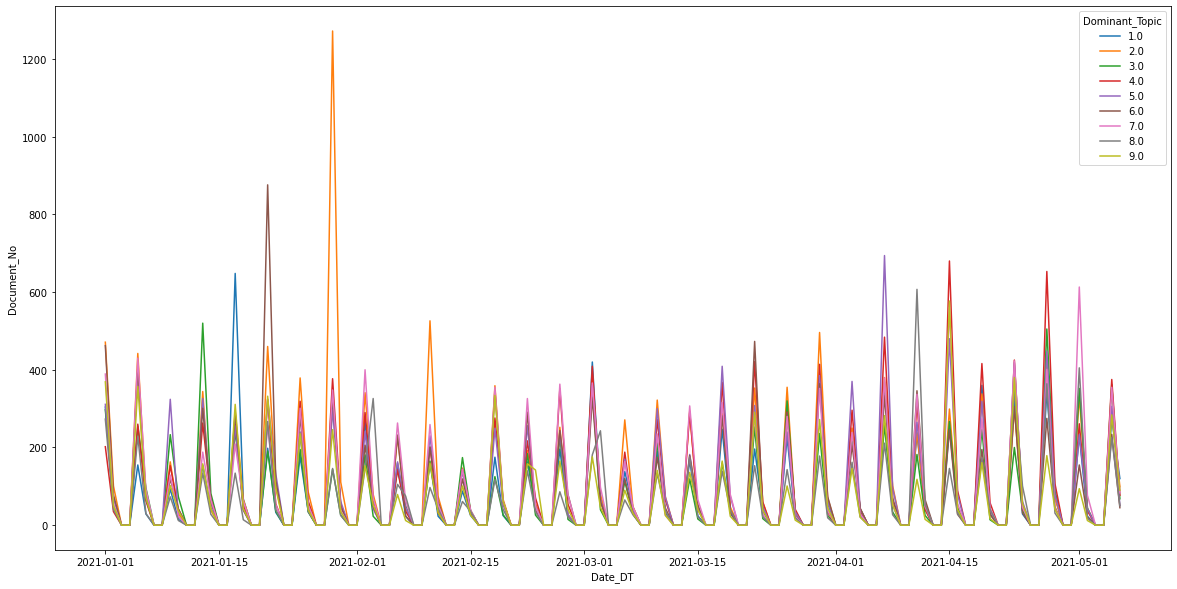

In [81]:
import seaborn as sns
f, ax = plt.subplots(1,1,figsize=(20,10))
sns.lineplot(data=topics_by_date[topics_by_date['Dominant_Topic']!='0.0'], x="Date_DT", y="Document_No", hue="Dominant_Topic",ax=ax)

<AxesSubplot:xlabel='Date_DT', ylabel='Document_No'>

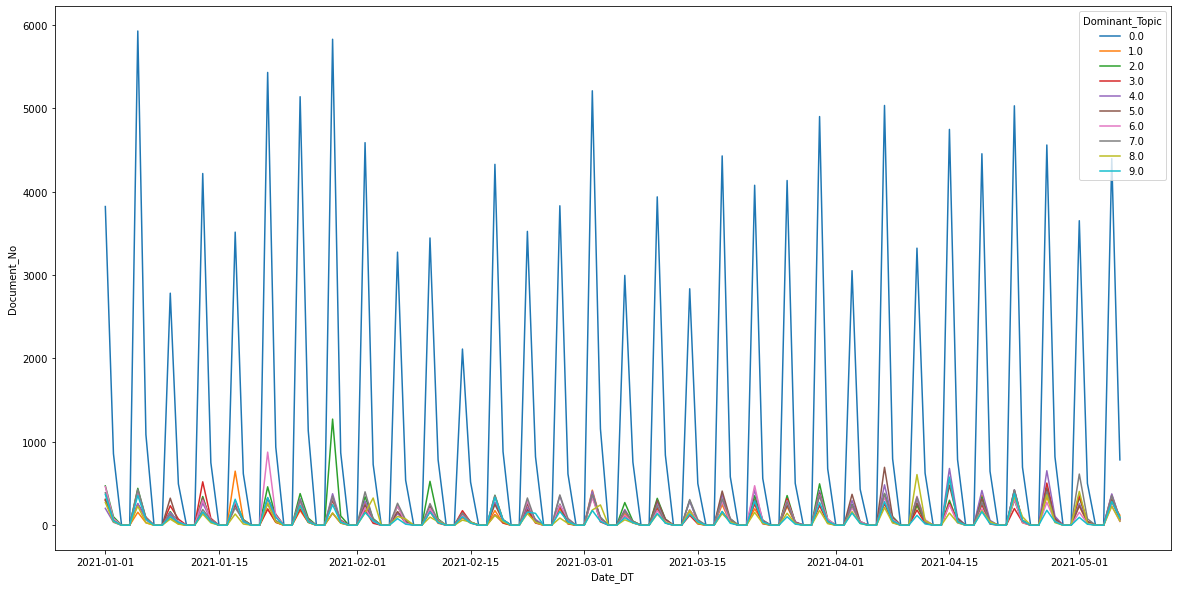

In [80]:
import seaborn as sns
f, ax = plt.subplots(1,1,figsize=(20,10))
sns.lineplot(data=topics_by_date, x="Date_DT", y="Document_No", hue="Dominant_Topic", ax=ax)

In [46]:
topics_by_week = df_dominant_topic.set_index('Date_DT').groupby(['Dominant_Topic']).resample('W')['Document_No'].nunique().reset_index()
topics_by_week['Dominant_Topic'] = topics_by_week['Dominant_Topic'] + 1
topics_by_week['Dominant_Topic'] = topics_by_week['Dominant_Topic'].astype(str)

Text(0, 0.5, 'Number of Tweets')

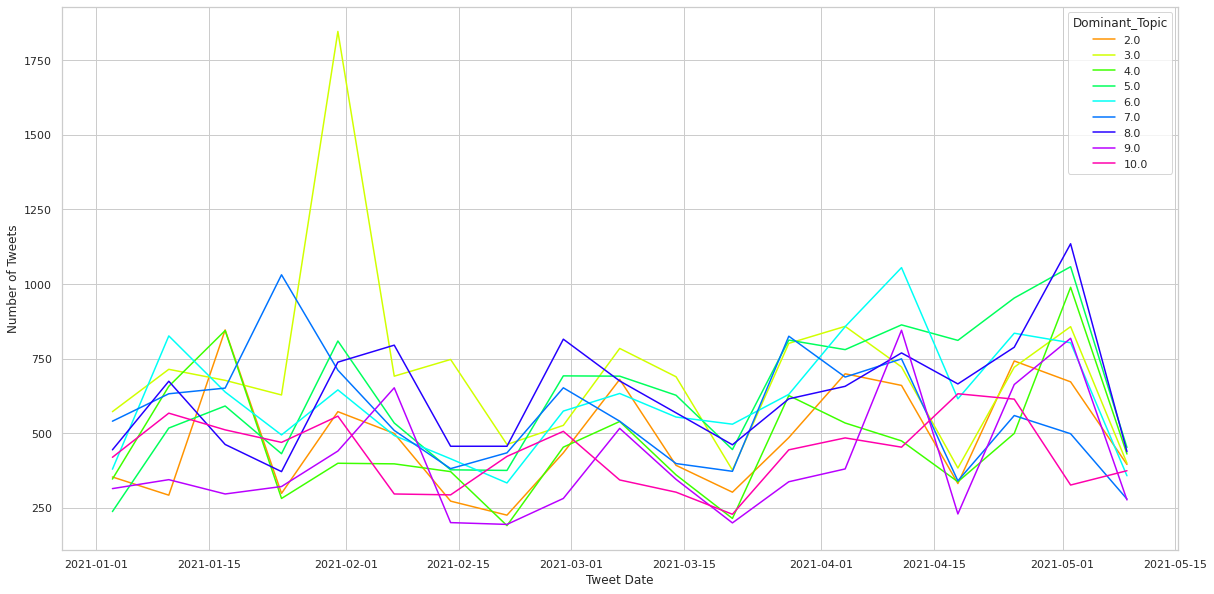

In [47]:
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
f, ax = plt.subplots(1,1,figsize=(20,10))
sns.lineplot(data=topics_by_week[topics_by_week['Dominant_Topic']!='1.0'], x="Date_DT", y="Document_No", hue="Dominant_Topic",ax=ax,palette='hsv')
ax.set_xlabel('Tweet Date')
ax.set_ylabel('Number of Tweets')


In [43]:
# Code modified from https://medium.com/swlh/topic-modeling-lda-mallet-implementation-in-python-part-2-602ffb38d396
topics = [[(term, round(wt, 3)) for term, wt in model_2.show_topic(n, topn=20)] for n in range(0, model_2.num_topics)]


In [44]:
# Code modified from https://medium.com/swlh/topic-modeling-lda-mallet-implementation-in-python-part-2-602ffb38d396
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, model_2.num_topics+1)] )
topics_df

,Terms per Topic
Topic1,"johnson johnson, second wave, people dying, fu..."
Topic2,"fake cards, people died, young people, new var..."
Topic3,"second dose, anti vax, high risk, biden admini..."
Topic4,"private school, big pharma, suspend patents, s..."
Topic5,"blood clots, joe rogan, social distancing, rep..."
Topic6,"wear mask, herd immunity, year old, long term,..."
Topic7,"pfizer biontech, adverse reactions, survival r..."
Topic8,"emergency use, new cases, use listing, cases t..."
Topic9,"raw materials, health officials, ennaid therap..."
Topic10,"patent protections, public health, blood clot,..."


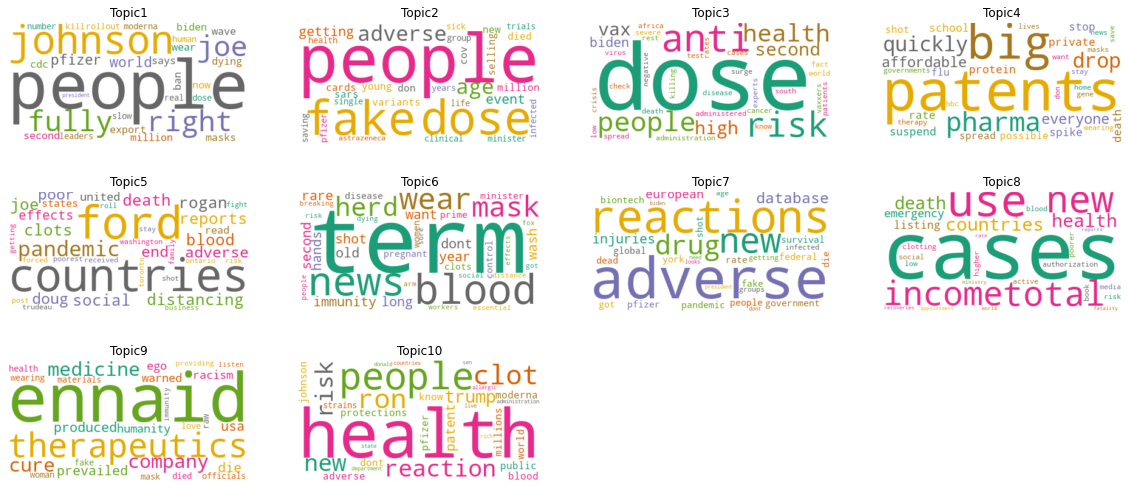

In [45]:
# Code modified from https://medium.com/swlh/topic-modeling-lda-mallet-implementation-in-python-part-2-602ffb38d396
# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=100)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(10):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

We can also try building a Mallet LDA model using either parameters identified above or any other parameters.

In [34]:
# Download MalletLDA with: wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/usr/lib/mallet-2.0.8/bin/mallet'
mallet_lda = gensim.models.wrappers.LdaMallet(mallet_path=mallet_path, corpus=tfidf_corpus, num_topics=8, alpha='0.3', id2word=single_dict)

Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 2
total tokens: 109676
<10> LL/token: -15.70288
<20> LL/token: -14.72522
<30> LL/token: -14.27988
<40> LL/token: -14.15302

0	0.0375	johnson mask pfizer blood wear adverse astrazeneca masks clots moderna wearing anti events clot human vax oxford rights boris biontech 
1	0.0375	dose doses shot pandemic year flu york million received trump supply clinical fight wave ago single updates live trials chain 
2	0.0375	news countries emergency south fake africa minister poor pharma big prime cov sars variant common sputnik lives poorer good save 
3	0.0375	conspiracy people severe cases theories disease rollout slow don virus post school private distribution theory plan warn experts illness die 
4	0.0375	dont biden immunity herd home nursing age government federal test negative study administration joe desantis variants life shows years president 
5	0.0375	health workers public cases officials healthcare minister care de

In [35]:
print(mallet_lda.show_topics())

[(0, 'nan*"selling fake" + nan*"first dose" + nan*"hong kong" + nan*"blood clots" + nan*"risk blood" + nan*"wait listen" + nan*"large gatherings" + nan*"toll active" + nan*"blood clotting" + nan*"hospitalization death"'), (1, 'nan*"selling fake" + nan*"first dose" + nan*"hong kong" + nan*"blood clots" + nan*"risk blood" + nan*"wait listen" + nan*"large gatherings" + nan*"toll active" + nan*"blood clotting" + nan*"hospitalization death"'), (2, 'nan*"selling fake" + nan*"first dose" + nan*"hong kong" + nan*"blood clots" + nan*"risk blood" + nan*"wait listen" + nan*"large gatherings" + nan*"toll active" + nan*"blood clotting" + nan*"hospitalization death"'), (3, 'nan*"selling fake" + nan*"first dose" + nan*"hong kong" + nan*"blood clots" + nan*"risk blood" + nan*"wait listen" + nan*"large gatherings" + nan*"toll active" + nan*"blood clotting" + nan*"hospitalization death"'), (4, 'nan*"selling fake" + nan*"first dose" + nan*"hong kong" + nan*"blood clots" + nan*"risk blood" + nan*"wait lis

In [98]:
coherence_model_malletlda = CoherenceModel(model=mallet_lda,texts=tweets_nn_lst, dictionary=single_dict, coherence='c_v')
coherence_malletlda = coherence_model_malletlda.get_coherence()
print(coherence_malletlda)

/home/npodpx/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  
0.3216132084984953


Other resources used: https://www.geeksforgeeks.org/python-convert-a-string-representation-of-list-into-list/; https://stackoverflow.com/questions/66759852/no-module-named-pyldavis; http://mallet.cs.umass.edu/download.php; https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/; https://thinkinfi.com/guide-to-build-best-lda-model-using-gensim-python/; https://medium.com/swlh/topic-modeling-lda-mallet-implementation-in-python-part-2-602ffb38d396; https://www.linkedin.com/pulse/nlp-a-complete-guide-topic-modeling-latent-dirichlet-sahil-m/; https://towardsdatascience.com/;basic-nlp-on-the-texts-of-harry-potter-topic-modeling-with-latent-dirichlet-allocation-f3c00f77b0f5; https://mickzhang.com/quality-control-for-banking-using-lda-and-lda-mallet/; http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf